## Requests of areas at different scales

### Imports

In [19]:
%matplotlib inline

# Utilities
import geopandas as gpd
import matplotlib.pyplot as plt
import itertools
import tempfile
import numpy as np
from pathlib import Path
from shapely.geometry import MultiLineString, MultiPolygon, Polygon, box, shape

# Sentinel Hub
from sentinelhub import (
    CRS,    
    ByocTile,
    SentinelHubBYOC,
    BBox,
    bbox_to_dimensions,
    BBoxSplitter,
    CustomGridSplitter,
    DataCollection,
    MimeType,
    MosaickingOrder,
    OsmSplitter,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    TileSplitter,
    UtmGridSplitter,
    UtmZoneSplitter,
    read_data,
    SHConfig
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

### Import additional packages

In [2]:
import rioxarray  # noqa: F401 # Its necesary for xarray.open_mfdataset() with engine `rasterio`
import xarray as xr  # It may need Dask library https://docs.dask.org/en/stable/install.html
from matplotlib.patches import Polygon as plt_polygon
from mpl_toolkits.basemap import Basemap  # Available here: https://github.com/matplotlib/basemap

### Set up credentials

In [3]:
# Insert your credentials here in case you don't already have them in config.json file:
SH_CLIENT_ID = ""
SH_CLIENT_SECRET = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

config = SHConfig()

if SH_CLIENT_ID and SH_CLIENT_SECRET:
    config.sh_client_id = SH_CLIENT_ID
    config.sh_client_secret = SH_CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Sentinel Hub BYOC API, please provide the credentials (client ID and client secret).")

### Example request with Process API

We will download data from Landsat 9

In [11]:
bbox = (-3.49,54.83,-2.97, 55.04) 

When the bounding box bounds have been defined, you can initialize the BBox of the area of interest. Using the bbox_to_dimensions utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape.

In [16]:
resolution = 20
bbox_wgs84 = BBox(bbox=bbox, crs=CRS.WGS84)
bbox_size = bbox_to_dimensions(bbox_wgs84, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {bbox_size} pixels")

Image shape at 20 m resolution: (1670, 1163) pixels


In [34]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LANDSAT_OT_L2,
            time_interval=("2022-03-01", "2022-03-01"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox_wgs84,
    size=bbox_size,
    config=config,
)

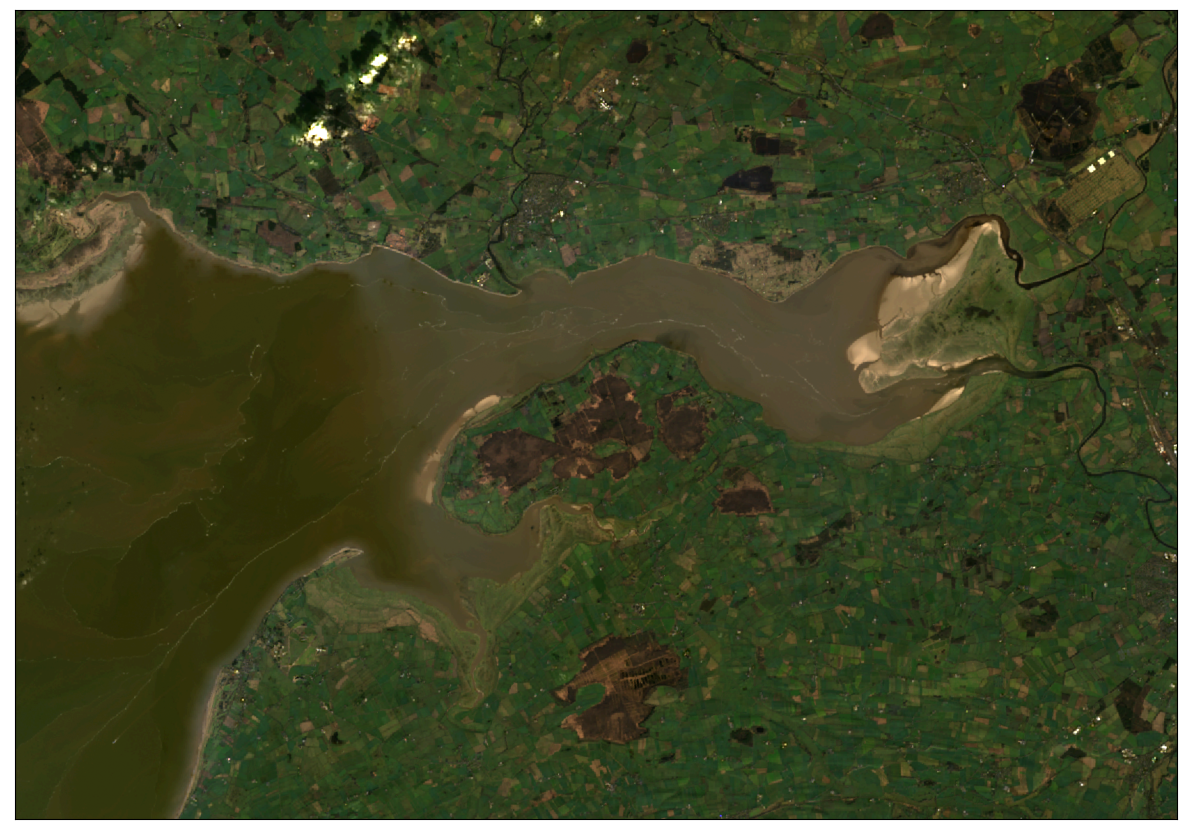

In [35]:
true_color_imgs = request_true_color.get_data()
image = true_color_imgs[0]
# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=4.5 / 255, clip_range=(0, 1))
